In [1]:
import tensorflow as tf
tf.__version__

import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal
import os
import pathlib
import glob

In [48]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, LSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers 

from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

In [3]:
# !pip install kapre

In [4]:
ROOT_PATH = 'speech/train'
AUDIO_PATH = 'speech/train/audio/'
NEW_PATH = 'speech/train/new/'
BACKGROUND_PATH = 'speech/train/audio/_background_noise_'
NOISE = 'speech/noise/'

In [5]:
labels = ['off', 'down', 'on', 'up', 'right', 'left']

In [6]:
def file_path(AUDIO_PATH):
    wav_list = []
    for root, dir_, files in os.walk(AUDIO_PATH):
        a = [str(root) + '/' + str(i) for i in files if i.endswith('.wav')]
    return a

bg_list = file_path(BACKGROUND_PATH)
bg_list

['speech/train/audio/_background_noise_/white_noise.wav',
 'speech/train/audio/_background_noise_/pink_noise.wav',
 'speech/train/audio/_background_noise_/doing_the_dishes.wav',
 'speech/train/audio/_background_noise_/dude_miaowing.wav',
 'speech/train/audio/_background_noise_/exercise_bike.wav',
 'speech/train/audio/_background_noise_/running_tap.wav']

In [7]:
# Get full path from the new noise added file
new_labels = []
noise_list = []
for root, dir_, files in os.walk(NOISE):
    if os.path.basename(root) in labels:
        new_labels.append(os.path.basename(root))
        a = [str(root) + '/' + str(i) for i in files]
        noise_list.append(a)
    else:
        pass

for ele in noise_list:
    print(len(ele))

2062
2143
2155
2165
2152
2105


In [8]:
new_labels

['up', 'off', 'right', 'left', 'down', 'on']

In [9]:
# Add my voice data to the list
for root, dir_, files in os.walk(NEW_PATH):
    if os.path.basename(root) in new_labels:
        a = [str(root) + '/' + str(i) for i in files]
        noise_list[new_labels.index(os.path.basename(root))].extend(a)
    else:
        pass

# We can see that the len of the sublist has changed   
for ele in noise_list:
    print(len(ele))

2083
2163
2155
2165
2173
2127


In [10]:
def load_file(path):
    sample, sample_rate = librosa.load(path, sr=16000)
    return sample

def mkdir(path):
    if os.path.exists(path) == True:
        pass
    else:
        os.mkdir(path)

In [11]:
# Test the sound of new file
idx = random.randint(0, 5)
print(new_labels[idx], idx)
sample = random.choice(noise_list[idx])
audio  = load_file(sample)
ipd.Audio(audio, rate=16000)

right 2


In [12]:
my_voice = noise_list[0][-1]
audio  = load_file(my_voice)
ipd.Audio(audio, rate=16000)


In [13]:
for i in range(len(labels)):
    path = NOISE + labels[i]
    mkdir(path)

# Add background noise
def add_noise(path1, path2):
    for i in range(len(path2)):
        path = 'speech/noise/' + path2[i].split('/')[-2] + '/'
        bg = random.choice(path1)
        bg, _ = librosa.load(bg, sr=16000, duration=1)
        target,_ = librosa.load(path2[i], sr=16000, duration=1)
        print(bg.shape, target.shape)
        try:
            join = np.array(target) + np.array(bg)
            librosa.output.write_wav(path + str(i) + '.wav', join, sr=16000)
        except:
            pass



In [14]:
# for i in range(len(wav_list)):
#     path2 = wav_list[i]
#     j = load_file(path2[0])
#     print(len(j))
#     add_noise(bg_list, path2)


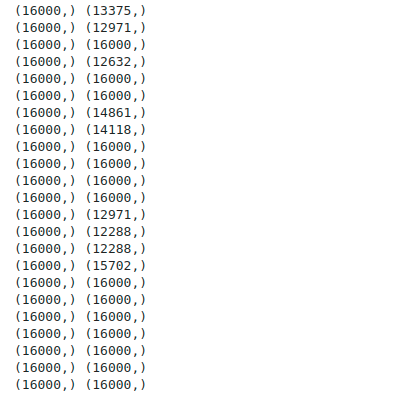

array([0.00015259, 0.00027466, 0.00033569, ..., 0.00143433, 0.00112915,
       0.00082397], dtype=float32)

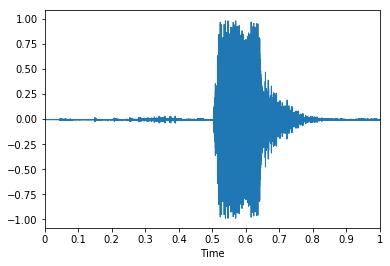

In [15]:
import librosa.display

def wave_plot(file):
    sample, rate = librosa.load(file, sr=16000)
    ipd.Audio(sample, rate=rate)
    wave, _ = librosa.effects.trim(sample)
    librosa.display.waveplot(wave, sr=16000)
    
    return wave

wave_plot(noise_list[0][0])

((128, 32),
 array([[-80.      , -80.      , -79.637   , ..., -75.18805 , -73.41026 ,
         -65.75433 ],
        [-80.      , -69.947044, -68.22731 , ..., -66.370056, -63.190964,
         -59.120674],
        [-80.      , -63.520714, -58.857998, ..., -66.64882 , -66.17797 ,
         -60.81303 ],
        ...,
        [-80.      , -78.89319 , -74.40145 , ..., -78.44221 , -77.46844 ,
         -76.36228 ],
        [-80.      , -75.94166 , -73.806244, ..., -77.817696, -76.641975,
         -76.62143 ],
        [-80.      , -78.822464, -76.60839 , ..., -76.56338 , -74.65166 ,
         -71.93613 ]], dtype=float32))

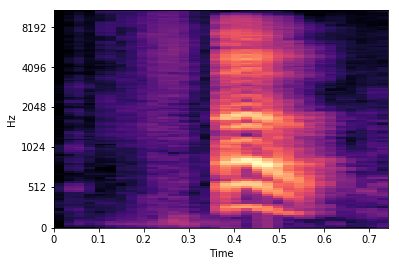

In [16]:
def plot_spec(file):
    sample, rate = librosa.load(file, sr=16000)
    train_spec = librosa.feature.melspectrogram(sample, sr=16000) 
    train_spec = librosa.power_to_db(train_spec, ref=np.max)
    librosa.display.specshow(train_spec, x_axis='time', y_axis='mel')

    return (train_spec.shape, train_spec)

plot_spec(noise_list[0][0])

((128, 32), array([[-38.385136 , -38.955265 , -31.704786 , ..., -16.290924 ,
         -21.260635 , -37.658714 ],
        [-37.880943 , -42.953487 , -44.06394  , ..., -11.2057705,
         -24.88948  , -40.822132 ],
        [-28.799429 , -28.95278  , -30.640112 , ..., -12.544168 ,
         -28.220547 , -33.229496 ],
        ...,
        [-72.36668  , -73.703575 , -73.25348  , ..., -73.1594   ,
         -75.59643  , -77.19233  ],
        [-71.624756 , -76.757706 , -79.95301  , ..., -79.03991  ,
         -80.       , -80.       ],
        [-73.079895 , -79.00739  , -80.       , ..., -80.       ,
         -80.       , -80.       ]], dtype=float32))

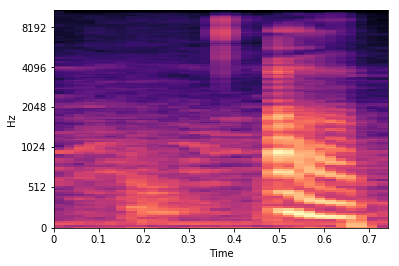

In [17]:
plot_spec(my_voice)

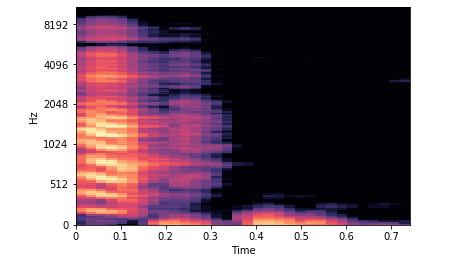

In [18]:
# frequen, times, spectogram = signal.spectrogram(load, sample_rate)
# print(spectogram.shape, spectogram[0][:])

In [19]:
## Funtion to save spectrogram pic
def save_pic(sample, sr=16000):
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    spec_features = librosa.feature.melspectrogram(sample, sr=sr)
    spec_db = librosa.power_to_db(spec_features, ref=np.max)

    librosa.display.specshow(spec_db, x_axis='time', y_axis='mel')

    plt.savefig('spec.jpg', dpi=400, bbox_inches='tight', pad_inches=0)

## Prepare training data 

In [34]:
import itertools

X = []
y = []
noise_merged = list(itertools.chain(*noise_list))

for i in noise_merged:
    label = i.split('/')[-2]
    wave, _ = librosa.load(i, sr=16000)
    X.append(wave)
    y.append(label)

assert len(X) == len(y)

In [35]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((12866, 16000), (12866,))

In [36]:
y

array(['up', 'up', 'up', ..., 'on', 'on', 'on'], dtype='<U5')

In [37]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encode = LabelEncoder()
y = encode.fit_transform(y)
y = np_utils.to_categorical(y)
y

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

## CONVOLUTIONARY MODEL FOR SPEECH

In [38]:
from keras.models import Model, load_model

from keras.layers import Input, Activation, Concatenate, Permute, Reshape, Flatten, Lambda, Dot, Softmax
from keras.layers import Add, Dropout, BatchNormalization, Conv2D, Reshape, MaxPooling2D, Dense, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers

from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D

In [39]:
samplingrate = 16000
inputLength = 16000
nCategories = len(new_labels)

inputs = Input((inputLength,))

x = Reshape((1, -1)) (inputs)
x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, inputLength),
                             padding='same', sr=samplingrate, n_mels=80,
                             fmin=40.0, fmax=samplingrate/2, power_melgram=1.0,
                             return_decibel_melgram=True, trainable_fb=False,
                             trainable_kernel=False,
                             name='mel_stft') (x)
    
x = Normalization2D(int_axis=0)(x)
#note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
#we would rather have it the other way around for LSTMs

x = Permute((2,1,3)) (x)
#x = Reshape((94,80)) (x) #this is strange - but now we have (batch_size, sequence, vec_dim)

c1 = Conv2D(20, (5,1) , activation='relu', padding='same') (x)
c1 = BatchNormalization() (c1)
p1 = MaxPooling2D((2, 1)) (c1)
p1 = Dropout(0.03) (p1)

c2 = Conv2D(40, (3,3) , activation='relu', padding='same') (p1)
c2 = BatchNormalization() (c2)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.01) (p2)

c3 = Conv2D(80, (3,3) , activation='relu', padding='same') (p2)
c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)

p3 = Flatten()(p3)
p3 = Dense(64, activation = 'relu')(p3)
p3 = Dense(32, activation = 'relu')(p3)

output = Dense(nCategories, activation = 'softmax')(p3)

model = Model(inputs=[inputs], outputs=[output], name='ConvSpeechModel')

model.summary()

tracking <tf.Variable 'mel_stft/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft/Variable:0' shape=(513, 80) dtype=float32> freq2mel


/home/jupyter/.local/lib/python3.5/site-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


Model: "ConvSpeechModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 16000)          0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_1 (Normaliza (None, 80, 125, 1)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 125, 80, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 80, 20)       120       
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 80, 20)   

In [49]:
model.compile(metrics=['accuracy'], optimizer='adam', loss='categorical_crossentropy')
early = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=40, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.001)
checkpoint = ModelCheckpoint('models/CNN-Spec.hdf5', verbose=1, save_best_only=True)

In [50]:
BATCH = 128
model.fit(X, y, epochs = 50, batch_size=BATCH, shuffle=True, callbacks=[early, checkpoint, reduce_lr], validation_split=0.2)

Train on 10292 samples, validate on 2574 samples
Epoch 1/50
10292/10292 [==============================] - 8s 769us/step - loss: 0.5602 - accuracy: 0.7567 - val_loss: 197.0648 - val_accuracy: 0.0948

Epoch 00001: val_loss improved from inf to 197.06481, saving model to models/CNN-Spec.hdf5
Epoch 2/50
10292/10292 [==============================] - 7s 638us/step - loss: 0.5304 - accuracy: 0.7700 - val_loss: 174.2689 - val_accuracy: 0.1200

Epoch 00002: val_loss improved from 197.06481 to 174.26885, saving model to models/CNN-Spec.hdf5
Epoch 3/50
10292/10292 [==============================] - 7s 639us/step - loss: 0.5533 - accuracy: 0.7661 - val_loss: 183.2440 - val_accuracy: 0.0963

Epoch 00003: val_loss did not improve from 174.26885
Epoch 4/50
10292/10292 [==============================] - 7s 639us/step - loss: 0.5534 - accuracy: 0.7608 - val_loss: 159.3512 - val_accuracy: 0.1084

Epoch 00004: val_loss improved from 174.26885 to 159.35118, saving model to models/CNN-Spec.hdf5
Epoch 5/5

KeyboardInterrupt: 

In [ ]:
RNN.save('models/RNN-Spec.h5')

## RNN Speech Model

In [59]:
inputs = Input((16000,))

x = Reshape((1,-1))(inputs)

x = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, inputLength),
                             padding='same', sr=samplingrate, n_mels=80,
                             fmin=40.0, fmax=samplingrate/2, power_melgram=1.0,
                             return_decibel_melgram=True, trainable_fb=False,
                             trainable_kernel=False,
                             name='mel_stft') (x)

x = Normalization2D(int_axis=0)(x)

#note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
#we would rather have it the other way around for LSTMs

x = Permute((2,1,3))(x)

x = Conv2D(10, (5,1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(1, (5,1), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# reshape((125, 80))

x = Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim') (x) #keras.backend.squeeze(x, axis)

x = Bidirectional(LSTM(64, return_sequences = True)) (x) # [b_s, seq_len, vec_dim]
x = Bidirectional(LSTM(64)) (x)

x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(6, activation='softmax')(x)

RNN = Model(inputs=[inputs], outputs=[outputs])
RNN.summary()

tracking <tf.Variable 'mel_stft_1/real_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_real_kernels
tracking <tf.Variable 'mel_stft_1/imag_kernels:0' shape=(1024, 1, 1, 513) dtype=float32> dft_imag_kernels
tracking <tf.Variable 'mel_stft_1/Variable:0' shape=(513, 80) dtype=float32> freq2mel


/home/jupyter/.local/lib/python3.5/site-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 16000)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 1, 16000)          0         
_________________________________________________________________
mel_stft (Melspectrogram)    (None, 80, 125, 1)        1091664   
_________________________________________________________________
normalization2d_2 (Normaliza (None, 80, 125, 1)        0         
_________________________________________________________________
permute_2 (Permute)          (None, 125, 80, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 80, 10)       60        
_________________________________________________________________
batch_normalization_4 (Batch (None, 125, 80, 10)       40  

In [70]:
BATCH_SIZE = 128

adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(metrics=['accuracy'], optimizer=adam, loss='categorical_crossentropy')
early = EarlyStopping(monitor='val_loss', verbose=1, patience=50, min_delta=0.001)
checkpoint = ModelCheckpoint('models/RNN-Spec.hdf5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
model.fit(X, y, epochs = 100, batch_size= BATCH_SIZE, shuffle=True, callbacks=[early, checkpoint, reduce_lr], validation_split=0.1)

Train on 11579 samples, validate on 1287 samples
Epoch 1/100
11579/11579 [==============================] - 7s 590us/step - loss: 0.5141 - accuracy: 0.7886 - val_loss: 3.5868 - val_accuracy: 0.3869

Epoch 00001: val_loss improved from inf to 3.58678, saving model to models/RNN-Spec.hdf5
Epoch 2/100
11579/11579 [==============================] - 6s 476us/step - loss: 0.5144 - accuracy: 0.7878 - val_loss: 3.6639 - val_accuracy: 0.3683

Epoch 00002: val_loss did not improve from 3.58678
Epoch 3/100
11579/11579 [==============================] - 5s 474us/step - loss: 0.5273 - accuracy: 0.7819 - val_loss: 3.6011 - val_accuracy: 0.4118

Epoch 00003: val_loss did not improve from 3.58678
Epoch 4/100
11579/11579 [==============================] - 5s 475us/step - loss: 0.5370 - accuracy: 0.7797 - val_loss: 3.6076 - val_accuracy: 0.3761

Epoch 00004: val_loss did not improve from 3.58678
Epoch 5/100
11579/11579 [==============================] - 6s 475us/step - loss: 0.5288 - accuracy: 0.7824 - 

In [71]:
RNN.save('models/RNN-Spec.h5')